# Bearing Failure Anomaly Detection

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow.random import set_seed
import tensorflow as tf

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [2]:
# set random seed
seed(10)
set_seed(10)

# Data loading and pre-processing

In [3]:
# load, average and merge sensor samples
merged_data = pd.read_csv('./data/Averaged_BearingTest_Dataset.csv',index_col=0)

In [4]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index)
merged_data = merged_data.sort_index()
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data

In [5]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


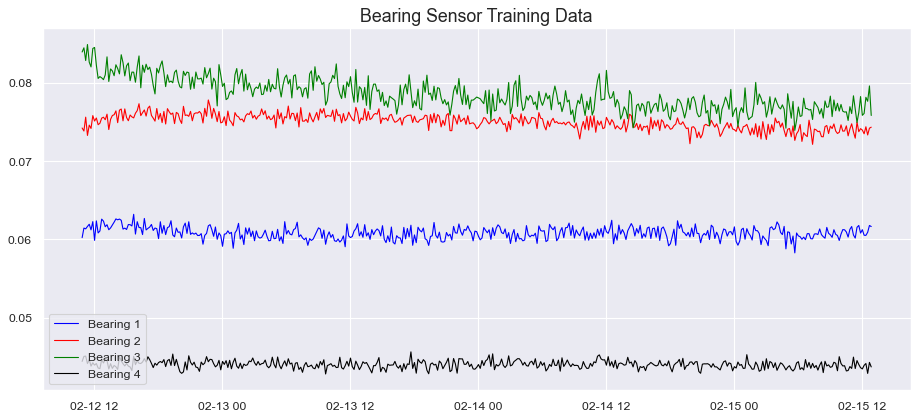

In [6]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [7]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

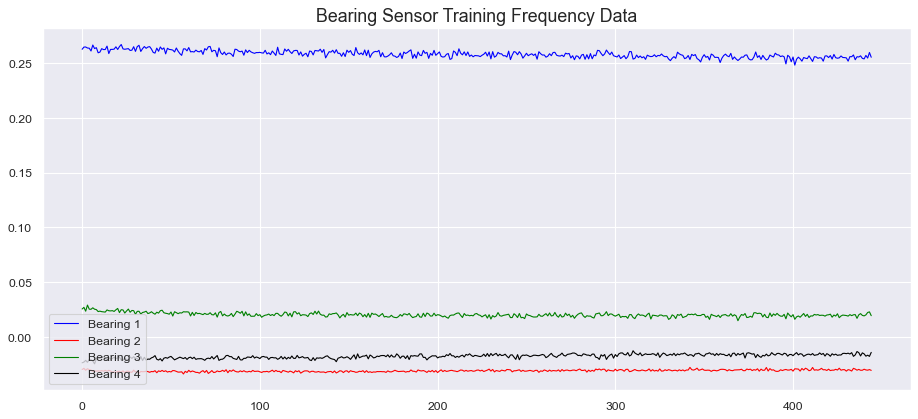

In [8]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

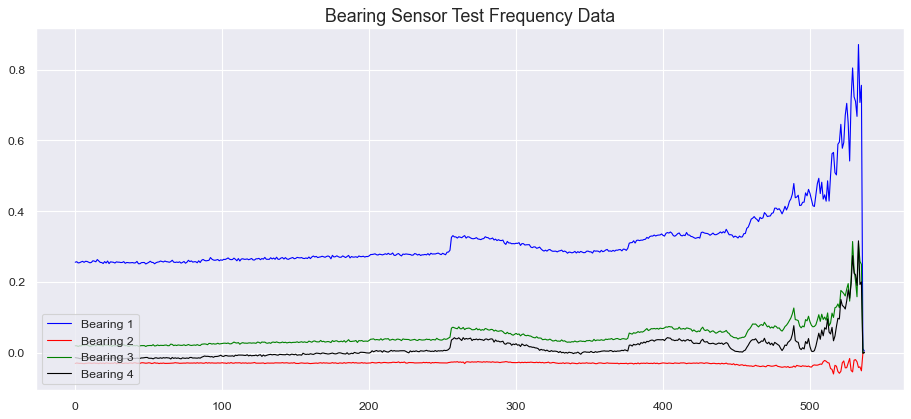

In [9]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [10]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# Model

## Machine learning (ML)

### Isolation Forest

In [11]:
clf = IsolationForest(random_state = 42)
clf.fit(X_train)
pred = clf.predict(X_train)

In [12]:
pca = PCA(n_components=2)
pca.fit(X_train)
printcipalComponents = pca.transform(X_train)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

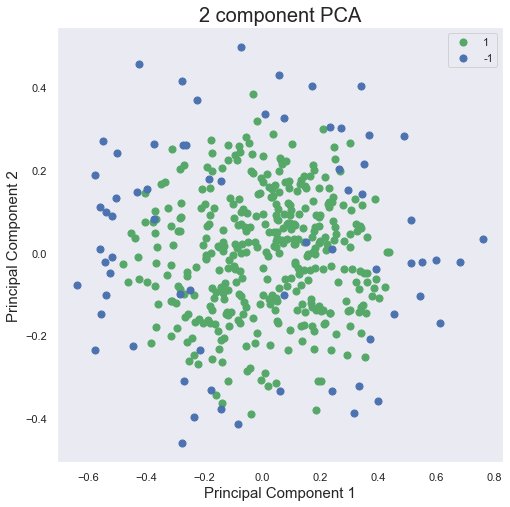

In [13]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [1, -1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [14]:
pred = clf.predict(X_test)

In [15]:
pca = PCA(n_components=2)
pca.fit(X_test)
printcipalComponents = pca.transform(X_test)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

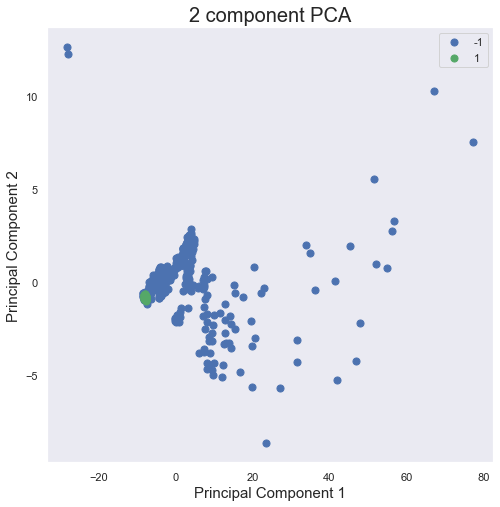

In [16]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### One Class SVM

In [17]:
clf = OneClassSVM(gamma='auto').fit(X_train)
pred = clf.predict(X_train)
pred_score = clf.score_samples(X_train)

In [18]:
pca = PCA(n_components=2)
pca.fit(X_train)
printcipalComponents = pca.transform(X_train)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

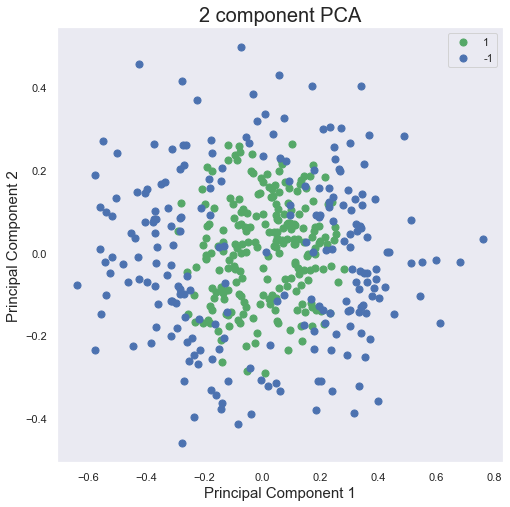

In [19]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [1, -1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [20]:
pred = clf.predict(X_test)

In [21]:
pca = PCA(n_components=2)
pca.fit(X_test)
printcipalComponents = pca.transform(X_test)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

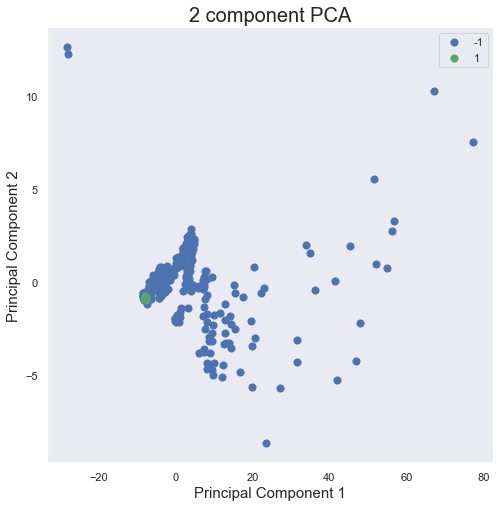

In [22]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Autoencoder

### ANN Autoencoder

In [23]:
# define the autoencoder network model
def ann_autoencoder_model(X):
    input_dim = X.shape[1]
    inputs = Input(shape=(X.shape[1],))
    encode = Dense(input_dim//3*2, activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)
    encode = BatchNormalization()(encode)
    encode = Dense(input_dim//3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
    encode = BatchNormalization()(encode)

    decode = Dense(input_dim//3, activation='relu')(encode)
    decode = BatchNormalization()(decode)
    decode = Dense(input_dim//3*2, activation='relu')(decode)
    decode = BatchNormalization()(decode)
    output = Dense(input_dim, activation='sigmoid')(decode)
    model = Model(inputs=inputs, outputs=output)
    return model

In [24]:
# create the autoencoder model
model = ann_autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
batch_normalization (BatchNo (None, 2)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1)                 4         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4     

In [25]:
# fit the model to the data
nb_epochs = 100
batch_size = 10

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/ann_autoencoder.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    callbacks=[es, mc],validation_split=0.05)

Epoch 1/100
43/43 [==============================] - 2s 19ms/step - loss: 0.0977 - mae: 0.1945 - val_loss: 0.0810 - val_mae: 0.1751

Epoch 00001: val_loss improved from inf to 0.08096, saving model to ./model\ann_autoencoder.h5
Epoch 2/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0914 - mae: 0.1865 - val_loss: 0.0793 - val_mae: 0.1748

Epoch 00002: val_loss improved from 0.08096 to 0.07926, saving model to ./model\ann_autoencoder.h5
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0799 - mae: 0.1688 - val_loss: 0.0768 - val_mae: 0.1718

Epoch 00003: val_loss improved from 0.07926 to 0.07683, saving model to ./model\ann_autoencoder.h5
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0724 - mae: 0.1557 - val_loss: 0.0744 - val_mae: 0.1687

Epoch 00004: val_loss improved from 0.07683 to 0.07439, saving model to ./model\ann_autoencoder.h5
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0706

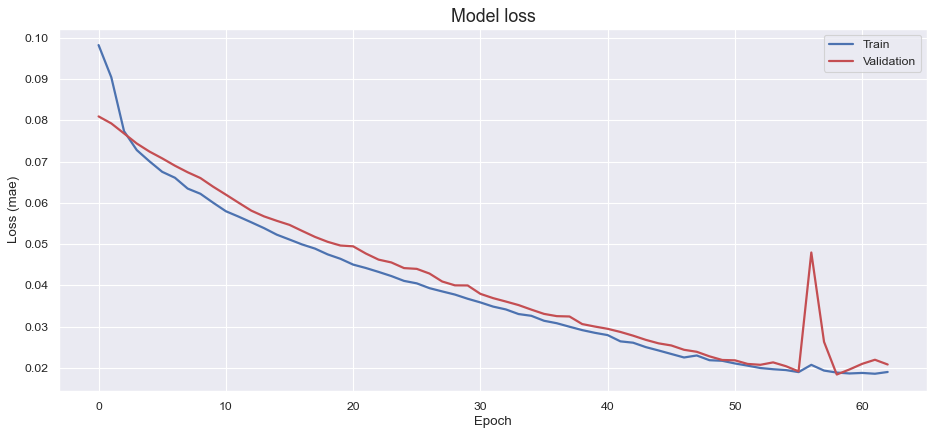

In [26]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [27]:
# load best model
model = load_model('./model/ann_autoencoder.h5')

C:\Users\user\anaconda3\envs\py38tf2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

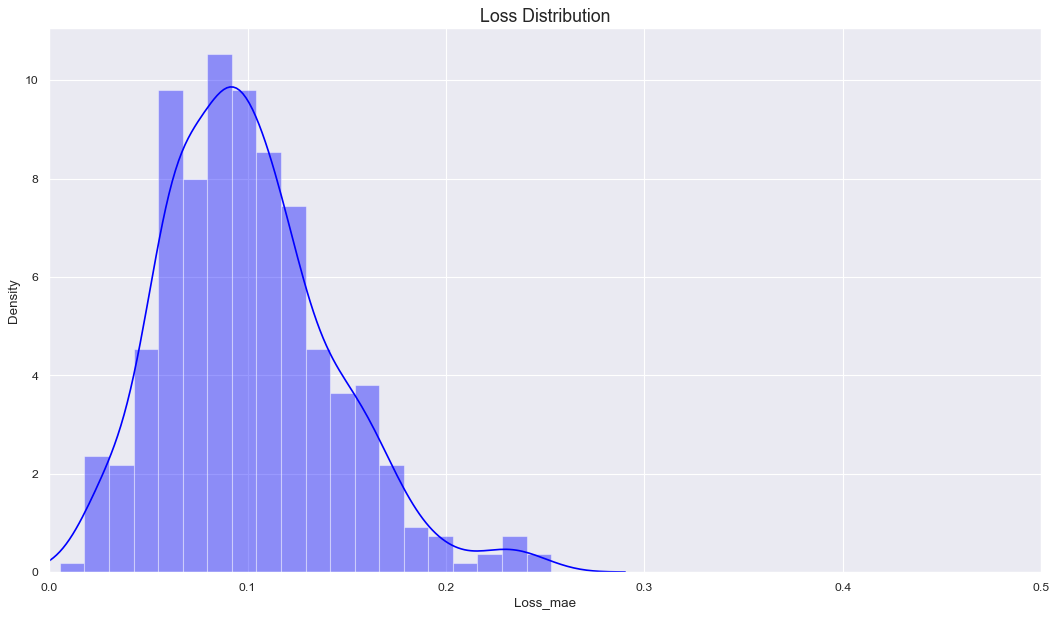

In [28]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [29]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.111532,0.275,False
2004-02-15 13:02:39,0.203659,0.275,False
2004-02-15 13:12:39,0.093592,0.275,False
2004-02-15 13:22:39,0.034371,0.275,False
2004-02-15 13:32:39,0.071713,0.275,False


In [30]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

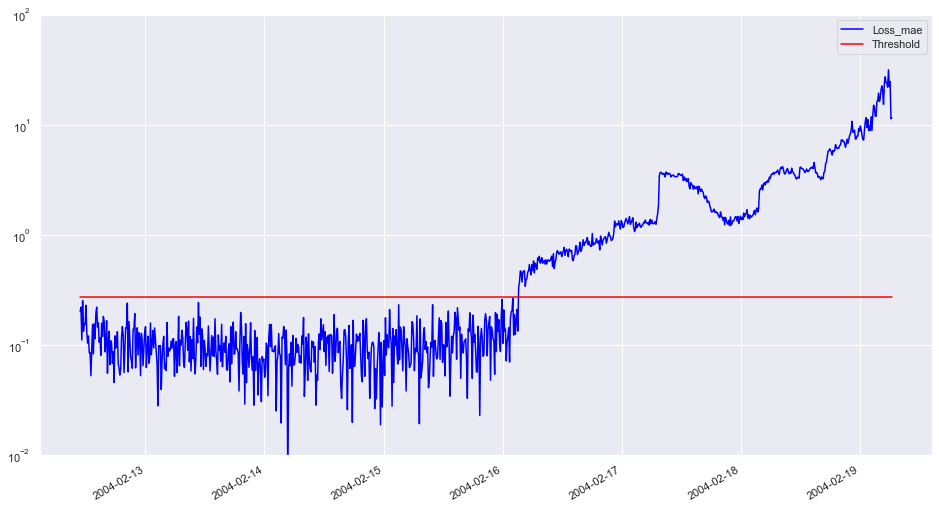

In [31]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

### LSTM Autoencoder

In [32]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0],  X_train.shape[1], 1)
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("Test data shape:", X_test.shape)

Training data shape: (445, 4, 1)
Test data shape: (538, 4, 1)


In [33]:
# define the autoencoder network model
def lstm_autoencoder_model(X):
    hidden_size = X.shape[1] * X.shape[2] // 2

    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(hidden_size, return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(hidden_size, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(hidden_size, return_sequences=True)(L3)
    L5 = LSTM(hidden_size, return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [34]:
# create the autoencoder model
model = lstm_autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 2)              32        
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 40        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 2)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 2)              40        
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 2)              40        
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 1)              3   

In [35]:
# fit the model to the data
nb_epochs = 100
batch_size = 10

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/lstm_autoencoder.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    callbacks=[es, mc], validation_split=0.05)

Epoch 1/100
43/43 [==============================] - 4s 23ms/step - loss: 0.2384 - mae: 0.4568 - val_loss: 0.1240 - val_mae: 0.3109

Epoch 00001: val_loss improved from inf to 0.12398, saving model to ./model\lstm_autoencoder.h5
Epoch 2/100
43/43 [==============================] - 0s 9ms/step - loss: 0.1756 - mae: 0.3796 - val_loss: 0.0763 - val_mae: 0.2214

Epoch 00002: val_loss improved from 0.12398 to 0.07625, saving model to ./model\lstm_autoencoder.h5
Epoch 3/100
43/43 [==============================] - 0s 8ms/step - loss: 0.1129 - mae: 0.2867 - val_loss: 0.0512 - val_mae: 0.1796

Epoch 00003: val_loss improved from 0.07625 to 0.05116, saving model to ./model\lstm_autoencoder.h5
Epoch 4/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0621 - mae: 0.2067 - val_loss: 0.0570 - val_mae: 0.2014

Epoch 00004: val_loss did not improve from 0.05116
Epoch 5/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0558 - mae: 0.1946 - val_loss: 0.0555 - val_mae: 

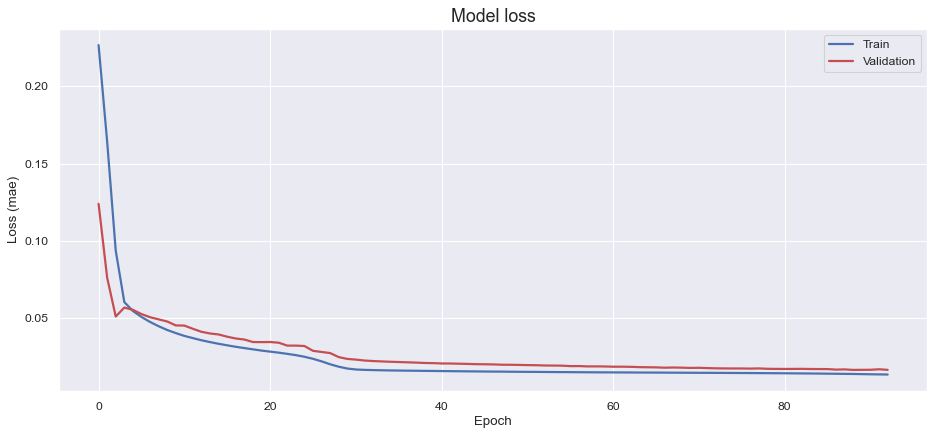

In [36]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [37]:
# load best model
model = load_model('./model/lstm_autoencoder.h5')

C:\Users\user\anaconda3\envs\py38tf2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

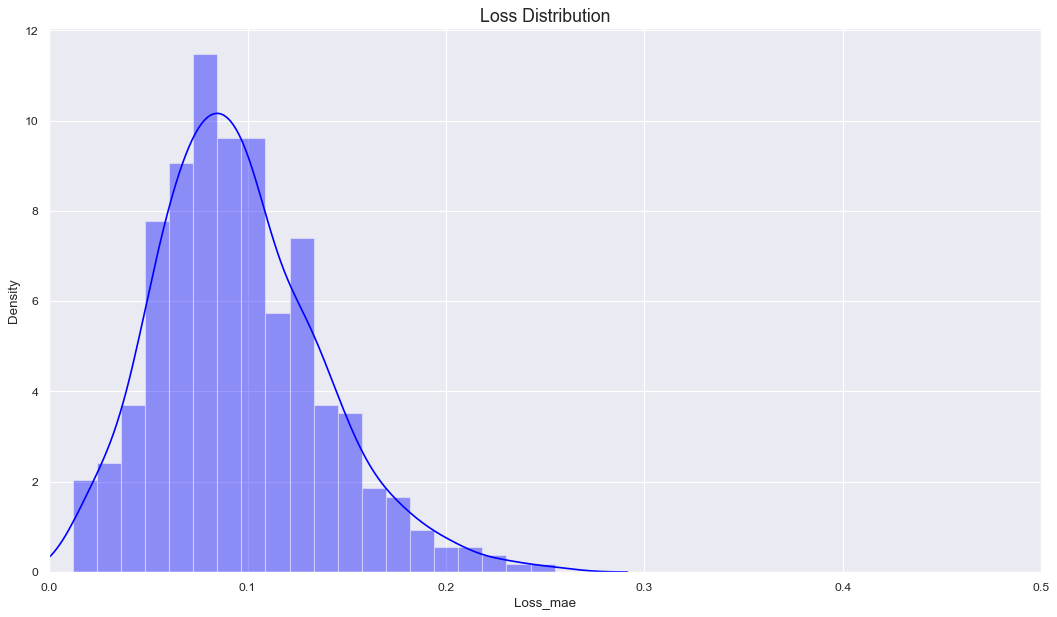

In [38]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [39]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.25
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.106398,0.25,False
2004-02-15 13:02:39,0.212795,0.25,False
2004-02-15 13:12:39,0.081269,0.25,False
2004-02-15 13:22:39,0.014543,0.25,False
2004-02-15 13:32:39,0.073532,0.25,False


In [40]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[1])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.25
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

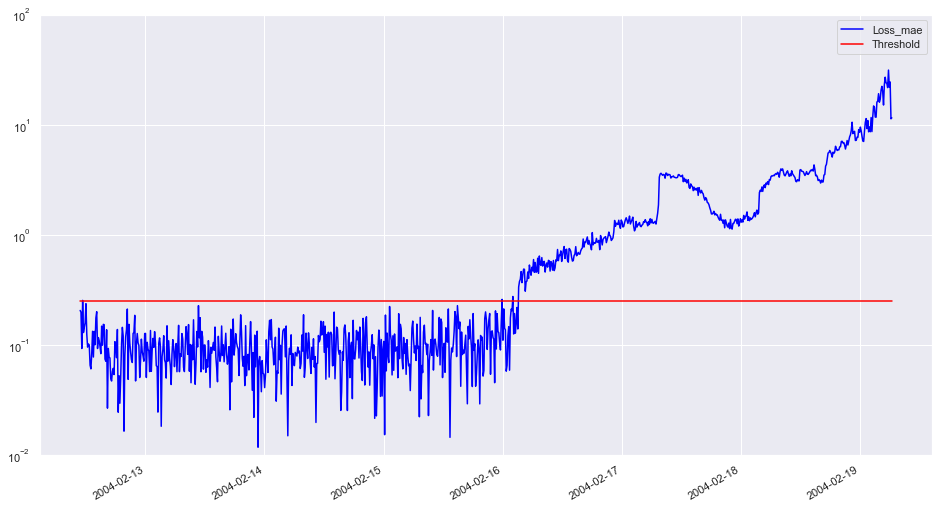

In [41]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

### Unsupervised log message anomaly detection
2 autoencoder + Isolation Forest

In [42]:
# reset train, test data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [43]:
# 1st Autoencoder
autoencoder1 = ann_autoencoder_model(X_train)
autoencoder1.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='loss', mode='min')
history1 = autoencoder1.fit(X_train, X_train,
        epochs=200,
        batch_size=10,
        shuffle=True,
        validation_split=0.05,
        callbacks = [early_stopping])
print('========== First Autoencoder Finish ==========')

# Isolation Forest
f1_pre = autoencoder1.predict(X_train)

clf = IsolationForest(random_state = 42, contamination = 0.3)
clf.fit(f1_pre)
pred = clf.predict(f1_pre)

p1 = f1_pre[pred==1]
p2 = f1_pre[pred==-1]

# 2st Autoencoder
autoencoder2 = ann_autoencoder_model(p1)
autoencoder2.compile(optimizer='adam', loss='mse', metrics=['mae'])

history2 = autoencoder2.fit(p1, p1,
        epochs=200,
        batch_size=10,
        shuffle=True,
        validation_split=0.05,
        callbacks = [early_stopping])
print('========== Second Autoencoder Finish ==========')

Epoch 1/200
43/43 [==============================] - 1s 10ms/step - loss: 0.0603 - mae: 0.1406 - val_loss: 0.0678 - val_mae: 0.1707
Epoch 2/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0579 - mae: 0.1426 - val_loss: 0.0628 - val_mae: 0.1675
Epoch 3/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0540 - mae: 0.1419 - val_loss: 0.0586 - val_mae: 0.1648
Epoch 4/200
43/43 [==============================] - 0s 7ms/step - loss: 0.0506 - mae: 0.1406 - val_loss: 0.0548 - val_mae: 0.1625
Epoch 5/200
43/43 [==============================] - 0s 7ms/step - loss: 0.0485 - mae: 0.1414 - val_loss: 0.0519 - val_mae: 0.1611
Epoch 6/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0440 - mae: 0.1373 - val_loss: 0.0492 - val_mae: 0.1597
Epoch 7/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0431 - mae: 0.1391 - val_loss: 0.0469 - val_mae: 0.1584
Epoch 8/200
43/43 [==============================] - 0s 7ms/step - loss: 0.0425 - 

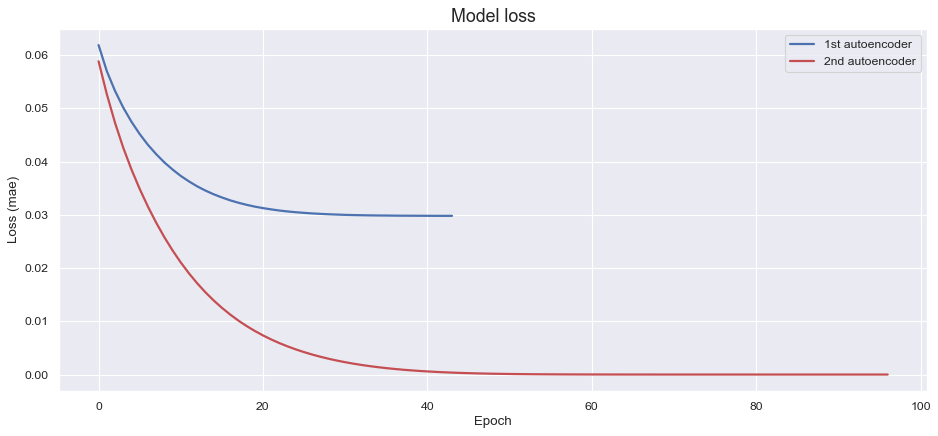

In [44]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1.history['loss'], 'b', label='1st autoencoder', linewidth=2)
ax.plot(history2.history['loss'], 'r', label='2nd autoencoder', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

C:\Users\user\anaconda3\envs\py38tf2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

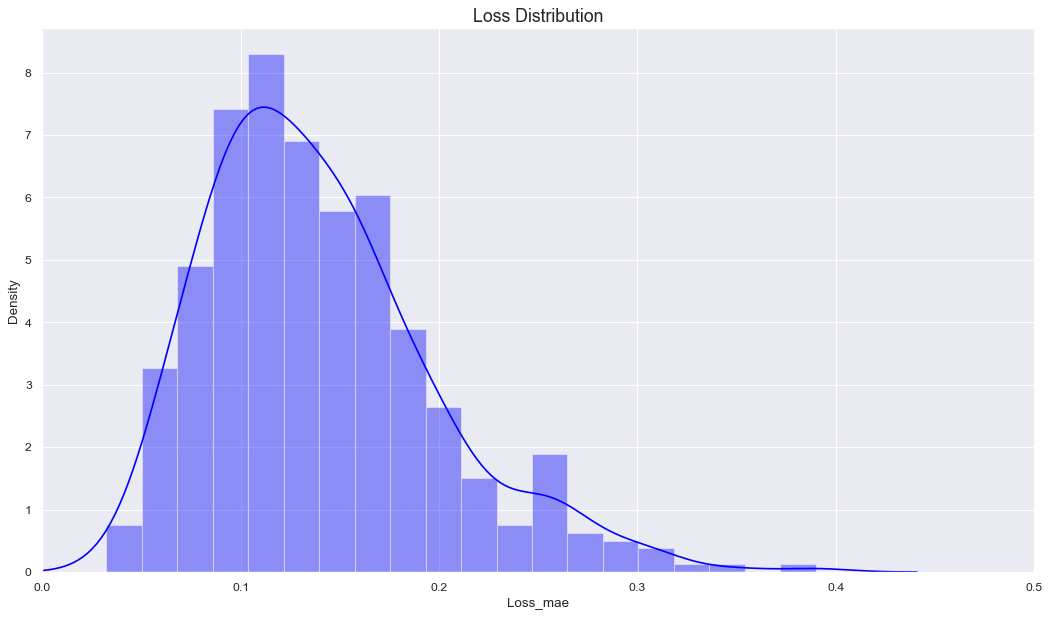

In [45]:
# plot the loss distribution of the training set
X_pred = autoencoder2.predict(autoencoder1.predict(X_train))
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [46]:
# calculate the loss on the test set
X_pred = autoencoder2.predict(autoencoder1.predict(X_test))
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.375
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.164771,0.375,False
2004-02-15 13:02:39,0.203675,0.375,False
2004-02-15 13:12:39,0.162726,0.375,False
2004-02-15 13:22:39,0.181921,0.375,False
2004-02-15 13:32:39,0.091424,0.375,False


In [47]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = autoencoder2.predict(autoencoder1.predict(X_train))
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.375
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

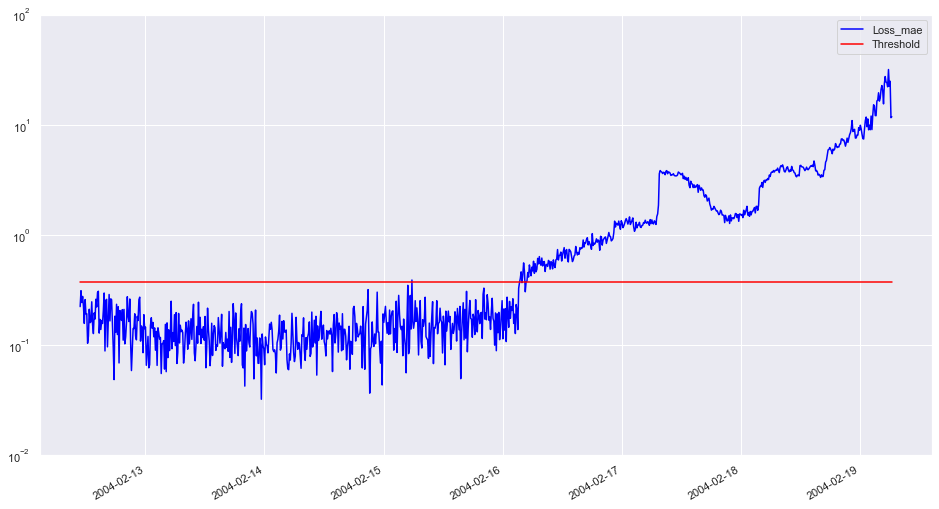

In [48]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])